In [1]:
import pandas as pd
import pickle
import numpy as np
import xgboost
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns",80)

In [2]:
df = pd.read_csv('../data/final_data.csv')
# df = pd.read_csv('../data/positive_feature.csv')
df = df.dropna(how='any',axis=0)
print(df)

                  timestamp ACCIDENTDATE ACCIDENTTIME  Route_No  \
0       2006-02-23 15:00:00   2006-02-23     15:00:00    180994   
1       2006-02-23 15:00:00   2006-02-23     15:00:00    213222   
2       2006-02-06 21:00:00   2006-02-06     21:00:00      5044   
3       2006-02-06 21:00:00   2006-02-06     21:00:00    138932   
4       2006-01-09 17:00:00   2006-01-09     17:00:00      5026   
5       2006-01-09 17:00:00   2006-01-09     17:00:00      5044   
6       2006-01-09 17:00:00   2006-01-09     17:00:00    150347   
7       2006-01-24 17:00:00   2006-01-24     17:00:00      2090   
8       2006-01-24 17:00:00   2006-01-24     17:00:00    159508   
9       2006-02-24 07:00:00   2006-02-24     07:00:00      2460   
10      2006-02-24 07:00:00   2006-02-24     07:00:00    105177   
11      2006-01-17 08:00:00   2006-01-17     08:00:00      5127   
12      2006-03-05 21:00:00   2006-03-05     21:00:00      5127   
13      2006-01-17 08:00:00   2006-01-17     08:00:00      587

In [3]:
one_hot_field = ['hour', 'DAY_OF_WEEK', 'month', 'Light_Condition', 'ROAD_TYPE', 'wind_dir', 'SURFACE_COND', 'NODE_TYPE', 'Deg_Urban_Name']
# one_hot_field = ['DAY_OF_WEEK']
# One-Hot encode a couple of variables
df_one_hot = pd.get_dummies(df,columns=one_hot_field)

# Get the one-hot variable names
one_hot_feature_names = pd.get_dummies(df[one_hot_field],columns=one_hot_field).columns.tolist()
df_one_hot.head()

,timestamp,ACCIDENTDATE,ACCIDENTTIME,Route_No,segment_id,SPEED_ZONE,DIRECTION_LOCATION,snowing,raining,foggy,smoke,dust,strong_winds,wind_speed,temperature,target,accident_counts,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,...,ROAD_TYPE_VALLEY,ROAD_TYPE_VIEW,ROAD_TYPE_VISTA,ROAD_TYPE_W,ROAD_TYPE_WALK,ROAD_TYPE_WAY,ROAD_TYPE_WEST,ROAD_TYPE_WYND,wind_dir_CALM,wind_dir_E,wind_dir_ENE,wind_dir_ESE,wind_dir_N,wind_dir_NE,wind_dir_NNE,wind_dir_NNW,wind_dir_NW,wind_dir_S,wind_dir_SE,wind_dir_SSE,wind_dir_SSW,wind_dir_SW,wind_dir_W,wind_dir_WNW,wind_dir_WSW,SURFACE_COND_1,SURFACE_COND_2,SURFACE_COND_3,SURFACE_COND_4,SURFACE_COND_5,SURFACE_COND_9,NODE_TYPE_I,NODE_TYPE_N,Deg_Urban_Name_LARGE_PROVINCIAL_CITIES,Deg_Urban_Name_MELBOURNE_CBD,Deg_Urban_Name_MELB_URBAN,Deg_Urban_Name_RURAL_VICTORIA,Deg_Urban_Name_SMALL_CITIES,Deg_Urban_Name_SMALL_TOWNS,Deg_Urban_Name_TOWNS
0,2006-02-23 15:00:00,2006-02-23,15:00:00,180994,1140706800180994,60,N,0,0,0,0,0,0,12.0,93.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,2006-02-23 15:00:00,2006-02-23,15:00:00,213222,1140706800213222,60,N,0,0,0,0,0,0,12.0,93.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,2006-02-06 21:00:00,2006-02-06,21:00:00,5044,11392596005044,60,SE,0,0,0,0,0,0,18.0,59.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,2006-02-06 21:00:00,2006-02-06,21:00:00,138932,1139259600138932,60,SE,0,0,0,0,0,0,18.0,59.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,2006-01-09 17:00:00,2006-01-09,17:00:00,5026,11368260005026,60,SW,0,0,0,0,0,0,7.0,74.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0


## Features
These are currently:

- hour
- DAY_OF_WEEK
- month
- SPEED_ZONE
- Light_Condition
- ROAD_TYPE
- DIRECTION_LOCATION
- snowing
- raining
- foggy
- smoke
- dust
- strong_winds
- wind_dir
- wind_speed
- temperature
- SURFACE_COND
- NODE_TYPE
- Deg_Urban_Name

These will be rescaled by scikit-learn's standard rescaler

In [4]:
y = df['target'].values
float_feature_names = [
    'SPEED_ZONE',
    'wind_speed',
    'temperature',
]
float_features = df_one_hot.xs(float_feature_names,axis=1).values
# Use scikit-learn's StandardScaler
scaler = StandardScaler()
float_scaled = scaler.fit_transform(float_features)
#print (float_features.mean(axis=0))

df_one_hot[float_feature_names] = float_scaled

with open('scalers.pkl','wb') as fp:
    pickle.dump(scaler,fp)

In [5]:
print(df_one_hot)

                  timestamp ACCIDENTDATE ACCIDENTTIME  Route_No  \
0       2006-02-23 15:00:00   2006-02-23     15:00:00    180994   
1       2006-02-23 15:00:00   2006-02-23     15:00:00    213222   
2       2006-02-06 21:00:00   2006-02-06     21:00:00      5044   
3       2006-02-06 21:00:00   2006-02-06     21:00:00    138932   
4       2006-01-09 17:00:00   2006-01-09     17:00:00      5026   
5       2006-01-09 17:00:00   2006-01-09     17:00:00      5044   
6       2006-01-09 17:00:00   2006-01-09     17:00:00    150347   
7       2006-01-24 17:00:00   2006-01-24     17:00:00      2090   
8       2006-01-24 17:00:00   2006-01-24     17:00:00    159508   
9       2006-02-24 07:00:00   2006-02-24     07:00:00      2460   
10      2006-02-24 07:00:00   2006-02-24     07:00:00    105177   
11      2006-01-17 08:00:00   2006-01-17     08:00:00      5127   
12      2006-03-05 21:00:00   2006-03-05     21:00:00      5127   
13      2006-01-17 08:00:00   2006-01-17     08:00:00      587

In [6]:
binary_feature_names = [
    'snowing',
    'raining',
    'foggy',
    'smoke',
    'dust',
    'strong_winds',
]
df_one_hot = df_one_hot.xs(float_feature_names + binary_feature_names + one_hot_feature_names,axis=1)
# df_one_hot = df_one_hot.xs(float_feature_names + one_hot_feature_names,axis=1)

df_one_hot.head()

,SPEED_ZONE,wind_speed,temperature,snowing,raining,foggy,smoke,dust,strong_winds,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,DAY_OF_WEEK_0,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,...,ROAD_TYPE_VALLEY,ROAD_TYPE_VIEW,ROAD_TYPE_VISTA,ROAD_TYPE_W,ROAD_TYPE_WALK,ROAD_TYPE_WAY,ROAD_TYPE_WEST,ROAD_TYPE_WYND,wind_dir_CALM,wind_dir_E,wind_dir_ENE,wind_dir_ESE,wind_dir_N,wind_dir_NE,wind_dir_NNE,wind_dir_NNW,wind_dir_NW,wind_dir_S,wind_dir_SE,wind_dir_SSE,wind_dir_SSW,wind_dir_SW,wind_dir_W,wind_dir_WNW,wind_dir_WSW,SURFACE_COND_1,SURFACE_COND_2,SURFACE_COND_3,SURFACE_COND_4,SURFACE_COND_5,SURFACE_COND_9,NODE_TYPE_I,NODE_TYPE_N,Deg_Urban_Name_LARGE_PROVINCIAL_CITIES,Deg_Urban_Name_MELBOURNE_CBD,Deg_Urban_Name_MELB_URBAN,Deg_Urban_Name_RURAL_VICTORIA,Deg_Urban_Name_SMALL_CITIES,Deg_Urban_Name_SMALL_TOWNS,Deg_Urban_Name_TOWNS
0,-0.237223,0.195214,2.777713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,-0.237223,0.195214,2.777713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,-0.237223,1.207131,-0.112076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,-0.237223,1.207131,-0.112076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,-0.237223,-0.648050,1.162831,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [7]:
X = df_one_hot.values
y = df['target'].values
feature_names = df_one_hot.columns.tolist()

In [8]:
wrangler = {
    'scaler': scaler,
    'float_feature_names': float_feature_names,
    'one_hot_field': one_hot_field,
    'feature_names': feature_names
}
with open('wrangler_new.pkl','wb') as fp:
    pickle.dump(wrangler,fp)

## Define Model (Gradient Boosting)

In [9]:
feature_sel = range(len(feature_names))
#feature_sel = [-1,-2,-3]
Xs = X[:,feature_sel]
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.1)#, random_state=2)
fnames = np.array(feature_names)[feature_sel]

dtrain = xgboost.DMatrix(X_train,label=y_train,feature_names=fnames)
dtest =  xgboost.DMatrix(X_test,label=y_test,feature_names=fnames)

In [10]:
params = {
    'max_depth':6,
    'min_child_weight': 5.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'scale_pos_weight':1.0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'eta':0.5
}

In [11]:
booster = xgboost.train(params,dtrain,
    evals = [(dtest, 'eval')],
    num_boost_round=500,
    early_stopping_rounds=25
)

[13:11:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-auc:0.569342
Will train until eval-auc hasn't improved in 25 rounds.
[13:12:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-auc:0.594409
[13:12:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-auc:0.606766
[13:12:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[3]	eval-auc:0.66314
[13:12:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-auc:0.673232
[13:12:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[5]	eval-auc:0.689709
[13:12:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[6]	eval-auc:0.705391
[13:12:

[60]	eval-auc:0.852721
[13:16:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[61]	eval-auc:0.853186
[13:16:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[62]	eval-auc:0.853368
[13:16:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[63]	eval-auc:0.85555
[13:16:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[64]	eval-auc:0.856109
[13:17:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[65]	eval-auc:0.856762
[13:17:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[66]	eval-auc:0.858113
[13:17:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[67]	eval-auc:0.858551
[13:17:15] src/tree/updater_pr

[13:21:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[122]	eval-auc:0.893097
[13:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[123]	eval-auc:0.893755
[13:21:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[124]	eval-auc:0.894326
[13:21:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[125]	eval-auc:0.894726
[13:21:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[126]	eval-auc:0.895567
[13:21:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[127]	eval-auc:0.896102
[13:21:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[128]	eval-auc:0.896951
[13:21:29] src/tree/updater_prune.cc:74: tree 

[13:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[183]	eval-auc:0.919219
[13:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[184]	eval-auc:0.919302
[13:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[185]	eval-auc:0.919338
[13:25:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[186]	eval-auc:0.919402
[13:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[187]	eval-auc:0.919407
[13:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[188]	eval-auc:0.919669
[13:26:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[189]	eval-auc:0.919685
[13:26:05] src/tree/updater_prune.cc:74: tree p

[13:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[244]	eval-auc:0.935037
[13:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[245]	eval-auc:0.935043
[13:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[246]	eval-auc:0.935371
[13:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[247]	eval-auc:0.935525
[13:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[248]	eval-auc:0.935681
[13:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[249]	eval-auc:0.935807
[13:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[250]	eval-auc:0.935814
[13:30:15] src/tree/updater_prune.cc:74: tree p

[13:33:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[305]	eval-auc:0.94932
[13:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[306]	eval-auc:0.949424
[13:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[307]	eval-auc:0.949758
[13:33:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[308]	eval-auc:0.949841
[13:33:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[309]	eval-auc:0.949875
[13:33:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[310]	eval-auc:0.94997
[13:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[311]	eval-auc:0.950003
[13:34:03] src/tree/updater_prune.cc:74: tree pru

[13:37:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[366]	eval-auc:0.959012
[13:37:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[367]	eval-auc:0.959165
[13:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[368]	eval-auc:0.959212
[13:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[369]	eval-auc:0.959313
[13:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[370]	eval-auc:0.959327
[13:37:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[371]	eval-auc:0.959353
[13:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[372]	eval-auc:0.959428
[13:38:03] src/tree/updater_prune.cc:74: tree

[13:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[427]	eval-auc:0.965841
[13:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[428]	eval-auc:0.96597
[13:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[429]	eval-auc:0.966022
[13:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[430]	eval-auc:0.966162
[13:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[431]	eval-auc:0.966245
[13:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[432]	eval-auc:0.966391
[13:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[433]	eval-auc:0.966504
[13:42:47] src/tree/updater_prune.cc:74: tree

[13:47:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[488]	eval-auc:0.970774
[13:47:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[489]	eval-auc:0.970795
[13:47:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[490]	eval-auc:0.970813
[13:47:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[491]	eval-auc:0.97092
[13:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[492]	eval-auc:0.97098
[13:47:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[493]	eval-auc:0.971009
[13:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[494]	eval-auc:0.971093
[13:47:38] src/tree/updater_prune.cc:74: tree p

In [12]:
print(fnames)

['SPEED_ZONE' 'wind_speed' 'temperature' 'snowing' 'raining' 'foggy'
 'smoke' 'dust' 'strong_winds' 'hour_0' 'hour_1' 'hour_2' 'hour_3' 'hour_4'
 'hour_5' 'hour_6' 'hour_7' 'hour_8' 'hour_9' 'hour_10' 'hour_11' 'hour_12'
 'hour_13' 'hour_14' 'hour_15' 'hour_16' 'hour_17' 'hour_18' 'hour_19'
 'hour_20' 'hour_21' 'hour_22' 'hour_23' 'DAY_OF_WEEK_0' 'DAY_OF_WEEK_1'
 'DAY_OF_WEEK_2' 'DAY_OF_WEEK_3' 'DAY_OF_WEEK_4' 'DAY_OF_WEEK_5'
 'DAY_OF_WEEK_6' 'DAY_OF_WEEK_7' 'month_1' 'month_2' 'month_3' 'month_4'
 'month_5' 'month_6' 'month_7' 'month_8' 'month_9' 'month_10' 'month_11'
 'month_12' 'Light_Condition_1' 'Light_Condition_2' 'Light_Condition_3'
 'Light_Condition_4' 'Light_Condition_5' 'Light_Condition_6'
 'Light_Condition_9' 'ROAD_TYPE_ACCESS' 'ROAD_TYPE_ALLEY'
 'ROAD_TYPE_ARCADE' 'ROAD_TYPE_AVENUE' 'ROAD_TYPE_BEND'
 'ROAD_TYPE_BOULEVARD' 'ROAD_TYPE_BOULEVARDE' 'ROAD_TYPE_BREAK'
 'ROAD_TYPE_BYPASS' 'ROAD_TYPE_CAUSEWAY' 'ROAD_TYPE_CHASE'
 'ROAD_TYPE_CIRCLE' 'ROAD_TYPE_CIRCUIT' 'ROAD_TYPE_CLO

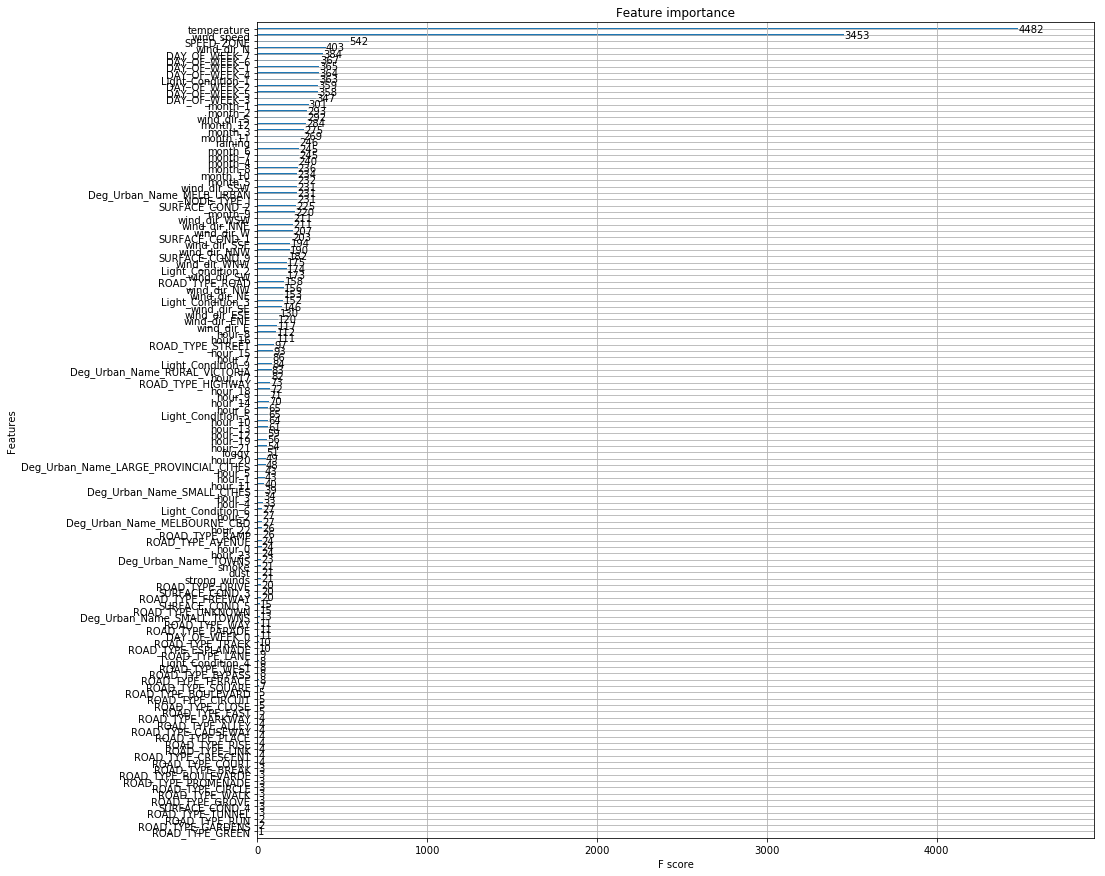

In [13]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster,ax=plt.gca(),importance_type='weight')

In [16]:
booster.save_model('./new_0001.model')

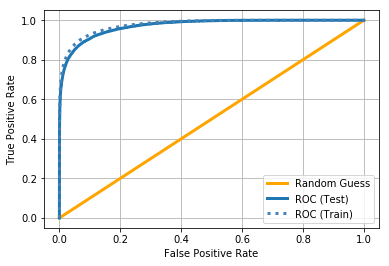

In [17]:
y_pred_test = booster.predict(dtest)

fpr, tpr, thresholds = roc_curve(y_test,y_pred_test)

y_pred_train = booster.predict(dtrain)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

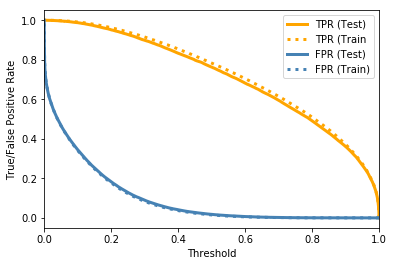

In [18]:
plt.plot(thresholds,tpr,'r-',label='TPR (Test)',color='orange',lw=3)
plt.plot(thresholds_train,tpr_train,'r:',label='TPR (Train',color='orange',lw=3)
plt.plot(thresholds,fpr,'r-',label='FPR (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,fpr_train,'r:',label='FPR (Train)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('True/False Positive Rate')
plt.legend()

'2.0.2'

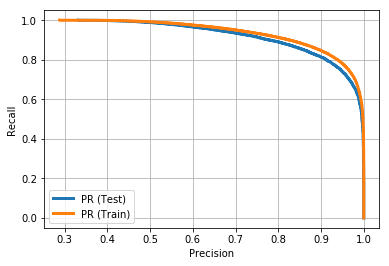

In [19]:
plt.figure(figsize=(15,15))

y_pred_test = booster.predict(dtest)
y_pred_train = booster.predict(dtrain)

precision,recall,thresholds = precision_recall_curve(y_test,y_pred_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot(precision,recall,label='PR (Test)',lw=3)
plt.plot(precision_train,recall_train,label='PR (Train)',lw=3)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.legend()
plt.matplotlib.__version__

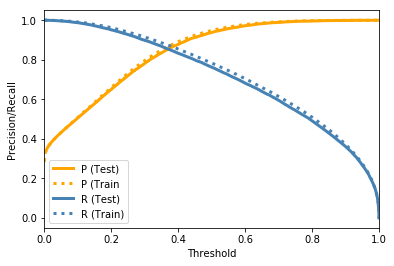

In [20]:
plt.plot(thresholds,precision[:-1],'r-',label='P (Test)',color='orange',lw=3)
plt.plot(thresholds_train,precision_train[:-1],'r:',label='P (Train',color='orange',lw=3)
plt.plot(thresholds,recall[:-1],'r-',label='R (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,recall_train[:-1],'r:',label='R (Train)',color='steelblue',lw=3)
#plt.plot([0,1],[0,1],'k-',lw=2)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()

In [21]:
y_pred_test = booster.predict(dtest) > 0.19
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(dtest)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))
print ('Test AP:',average_precision_score(y_test,y_pred_test))

y_pred_train = booster.predict(dtrain) > 0.19
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(dtrain)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))
print ('Test AP:',average_precision_score(y_train,y_pred_train))

Test Accuracy: 0.844793812863
Test F1: 0.764274263164
Test Precision: 0.636293634497
Test Recall: 0.956699598642
Test AUC: 0.971373832411
Test AP: 0.940619479329
Train Accuracy: 0.851132861266
Train F1: 0.773052205935
Train Precision: 0.644339041341
Train Recall: 0.966025445468
Train AUC: 0.977027139943
Test AP: 0.95158630741


In [22]:
def plot_split_histogram(feature_name):
    hist = booster.get_split_value_histogram(feature_name)
    try:
        i = float_feature_names.index(feature_name)
        fake_data = np.zeros((hist.Count.size,len(float_feature_names)))
        fake_data[:,i] = hist.SplitValue
        hist.loc[:,'SplitValue'] = scaler.inverse_transform(fake_data)[:,i]
    except: pass
    hist.plot(kind='area',x='SplitValue',y='Count')

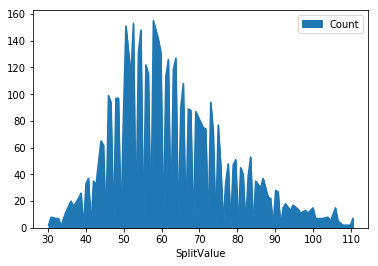

In [23]:
plot_split_histogram('temperature')

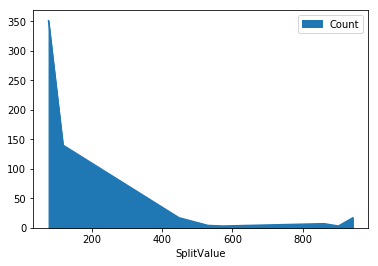

In [24]:
plot_split_histogram('SPEED_ZONE')

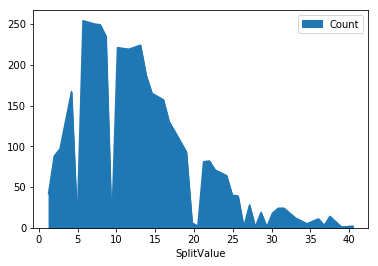

In [31]:
plot_split_histogram('wind_speed')